In [42]:
from ib_insync import *
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
util.startLoop() # uncomment this line in a jupyter notebook
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=0)

<IB connected to 127.0.0.1:7497 clientId=0>

In [44]:
ib.portfolio()

[]

In [45]:
ib.positions()

[]

In [56]:
cash = float([line for line in ib.accountSummary() if line.tag == 'TotalCashValue'][0].value)
cash
# ib.accountSummary()

200560.59

In [22]:
# Define the ETF contract
etf_contract = Stock('IUSQ', 'SMART', 'EUR') 
# Request historical data for the ETF
duration = '5 Y'  # Duration of historical data, e.g., '5 Y' for 5 years
barSize = '1 day'  # Bar size (1 month for monthly data)
historical_data = ib.reqHistoricalData(
    etf_contract,
    endDateTime='',
    durationStr=duration,
    barSizeSetting=barSize,
    whatToShow='TRADES',
    useRTH=True,
    formatDate=1
)

In [31]:
df = util.df(historical_data)

In [24]:
df

,date,open,high,low,close,volume,average,barCount
0,2018-11-08,41.805,41.825,41.645,41.775,2730.0,41.77523,15
1,2018-11-09,41.905,41.905,41.455,41.540,1299.0,41.60087,7
2,2018-11-12,41.835,41.850,41.060,41.060,6182.0,41.59691,14
3,2018-11-13,41.385,41.415,41.040,41.040,2002.0,41.26998,17
4,2018-11-14,40.965,41.290,40.700,40.700,3770.0,41.08096,12
...,...,...,...,...,...,...,...,...
1266,2023-10-31,61.940,62.600,61.860,62.600,120243.0,62.15276,476
1267,2023-11-01,62.650,63.380,62.500,63.320,180860.0,62.76645,461
1268,2023-11-02,63.290,64.240,63.220,64.220,93058.0,63.61633,484
1269,2023-11-03,64.150,64.410,64.020,64.360,75830.0,64.18224,395


In [32]:
# Convert 'date' to datetime and find the last trading day of each month
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df['month'] = df.index.to_period('M')
last_trading_day_of_month = df.groupby('month').agg('last').reset_index(drop=False)

# Calculate the 10-month and 50-month SMA on just the last trading day of each month
last_trading_day_of_month['10M_SMA'] = last_trading_day_of_month['close'].rolling(window=10).mean()
last_trading_day_of_month['50M_SMA'] = last_trading_day_of_month['close'].rolling(window=50).mean()


In [35]:
df[:60]

,open,high,low,close,volume,average,barCount,month
date,,,,,,,,
2018-11-08,41.805,41.825,41.645,41.775,2730.0,41.77523,15,2018-11
2018-11-09,41.905,41.905,41.455,41.540,1299.0,41.60087,7,2018-11
2018-11-12,41.835,41.850,41.060,41.060,6182.0,41.59691,14,2018-11
2018-11-13,41.385,41.415,41.040,41.040,2002.0,41.26998,17,2018-11
2018-11-14,40.965,41.290,40.700,40.700,3770.0,41.08096,12,2018-11
2018-11-15,40.930,41.105,40.445,41.105,74467.0,40.82190,33,2018-11
2018-11-16,40.990,40.990,40.685,40.895,4658.0,40.90040,9,2018-11
2018-11-19,40.975,40.975,40.145,40.145,766.0,40.81358,9,2018-11
2018-11-20,40.080,40.140,39.695,39.695,4229.0,40.02644,23,2018-11


In [34]:
last_trading_day_of_month

,month,open,high,low,close,volume,average,barCount,10M_SMA,50M_SMA
0,2018-11,40.990,41.310,40.930,41.310,2764.0,41.04636,14,NaN,NaN
1,2018-12,37.775,38.035,37.750,38.010,3936.0,37.93301,16,NaN,NaN
2,2019-01,40.800,41.070,40.635,41.070,2297.0,40.76350,23,NaN,NaN
3,2019-02,42.375,42.455,42.285,42.375,9049.0,42.35743,23,NaN,NaN
4,2019-03,43.370,43.510,43.295,43.510,3946.0,43.38920,8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
56,2023-07,66.240,66.410,66.100,66.380,75889.0,66.22593,469,61.72189,55.557152
57,2023-08,65.270,65.840,65.270,65.580,33786.0,65.59871,313,62.22789,55.981452
58,2023-09,64.580,64.980,64.300,64.440,90466.0,64.77681,363,62.54689,56.356652
59,2023-10,61.940,62.600,61.860,62.600,120243.0,62.15276,476,63.00900,56.709352


C:\Users\local_Johannes.Lange1\Temp\ipykernel_22856\3069859573.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_end_df['10M_SMA'] = month_end_df['close'].rolling(window=10).mean()


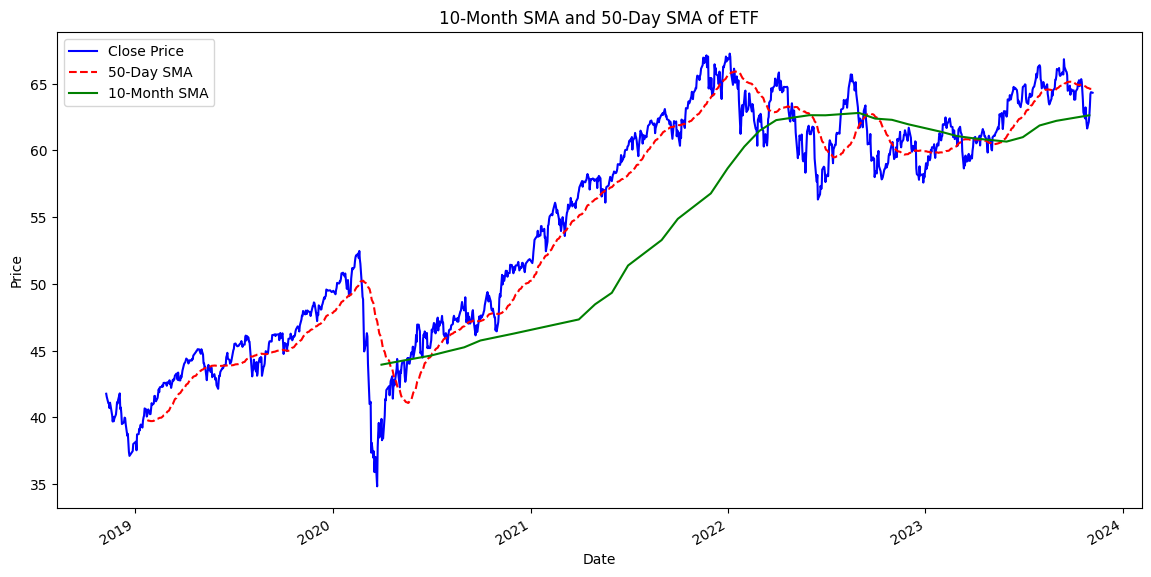

In [39]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd

# Helper function to find the last day of the month
def last_day_of_month(any_day):
    # The day 28 exists in every month. 4 days later, it's always next month
    next_month = any_day.replace(day=28) + dt.timedelta(days=4)
    # subtracting the number of the current day brings us back one month
    return (next_month - dt.timedelta(days=next_month.day)).day

# Add a column that identifies the last trading day of the month
df['last_day_of_month'] = df.index.map(last_day_of_month)

# Filter to keep only the last trading day of each month
month_end_df = df[df.index.day == df['last_day_of_month']]

# Calculate the 10M SMA on month-end data
month_end_df['10M_SMA'] = month_end_df['close'].rolling(window=10).mean()

# Calculate the 50D SMA on daily data
df['50D_SMA'] = df['close'].rolling(window=50).mean()

# Now let's plot the 10M SMA for month-end and the 50D SMA for daily data
plt.figure(figsize=(14, 7))

# Plot closing prices for the daily data
df['close'].plot(label='Close Price', color='blue')

# Plot 50-day SMA for the daily data
df['50D_SMA'].plot(label='50-Day SMA', color='red', linestyle='--')

# Plot 10-month SMA for month-end data
plt.plot(month_end_df.index, month_end_df['10M_SMA'], label='10-Month SMA', color='green')

# Title and labels
plt.title('10-Month SMA and 50-Day SMA of ETF')
plt.xlabel('Date')
plt.ylabel('Price')

# Legend
plt.legend()

# Show the plot
plt.show()


In [40]:
df

,open,high,low,close,volume,average,barCount,month,50D_SMA,10M_SMA,last_day_of_month
date,,,,,,,,,,,
2018-11-08,41.805,41.825,41.645,41.775,2730.0,41.77523,15,2018-11,NaN,NaN,30
2018-11-09,41.905,41.905,41.455,41.540,1299.0,41.60087,7,2018-11,NaN,NaN,30
2018-11-12,41.835,41.850,41.060,41.060,6182.0,41.59691,14,2018-11,NaN,NaN,30
2018-11-13,41.385,41.415,41.040,41.040,2002.0,41.26998,17,2018-11,NaN,NaN,30
2018-11-14,40.965,41.290,40.700,40.700,3770.0,41.08096,12,2018-11,NaN,NaN,30
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,61.940,62.600,61.860,62.600,120243.0,62.15276,476,2023-10,64.6350,63.009,31
2023-11-01,62.650,63.380,62.500,63.320,180860.0,62.76645,461,2023-11,64.6118,63.340,30
2023-11-02,63.290,64.240,63.220,64.220,93058.0,63.61633,484,2023-11,64.6140,63.340,30
